In [1]:
from Bio import Phylo
from Bio.Phylo.TreeConstruction import DistanceMatrix, DistanceTreeConstructor
from keyname import keyname as kn
from matplotlib import colors as mpl_colors
from teeplot import teeplot as tp

import Bio
import alifedata_phyloinformatics_convert as apc
import csv
import glob
import itertools
import json
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import networkx as nx
import numpy as np
import pandas as pd
import scipy as sci
import seaborn as sns
import urllib.request as request
import io
from copy import deepcopy


from etlib.SortableTree.SortableTree import SortableTree, find_leaves
from etlib.PlotTools.PlotTools import enable_pretty_graphing
enable_pretty_graphing()

In [2]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams["figure.figsize"] = (15, 20)
plt.rcParams["font.size"] = 13
plt.rcParams["font.weight"] = "bold"
plt.rcParams['font.family'] = 'Roboto'
plt.rcParams["lines.linewidth"] = 2
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.edgecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'white'

In [3]:
morphs = {x['stint']: x[' morph'][1:] for x in pd.read_csv('morphs_by_stint.csv').to_dict(orient='records')}
matrix = np.loadtxt("data/distance_matrix.matrix")
with open("data/stint_tags.json", 'r') as f:
    stint_tags = json.loads(f.read())

In [4]:
def to_tril(matrix):
    return [
        row[:row_idx] + [0.0]
        for row_idx, row in enumerate(matrix.tolist())
    ]

def fix_branch_length(root):
    if 'Inner' not in root.name:
        root.branch_length = 1
    else:
        root.branch_length = sum([x.branch_length for x in root]) / len([x.branch_length for x in root])
    for x in root:
        fix_branch_length(x)

def find_leaves(root):
    nodes = []
    for node in root.clades:
        if 'label' in node.__dict__:
            if node.label is not None:
                nodes.append(node.label)
            nodes.extend(find_leaves(node))
        elif 'name' in node.__dict__:
            if node.name is not None:
                nodes.append(node.name)
            nodes.extend(find_leaves(node))
    return nodes

In [5]:
class MyTreeMixin(Bio.Phylo.BaseTree.TreeMixin):
    def __init__(self, *args, **kwargs):
        super(MyTreeMixin, self).__init__(*args, **kwargs)
    def fix_inner_nodes(self):
        leaves = find_leaves(self.root)
        if leaves:
            min_leaf = min(leaves, default='0')
            name = str(min_leaf)
            self.root.label = name
            for node in self.root.clades:
                node.__class__ = MyClade
                node.fix_inner_nodes()
    def sort_tree(self, reverse=False):
        self.root.clades.sort(key=lambda x: int("".join(filter(str.isdigit, x.name))), reverse=reverse)
        for node in self.root.clades:
            node.__class__ = MyClade
            node.sort_tree(reverse=reverse)            
class MyTree(Bio.Phylo.BaseTree.Tree, Bio.Phylo.BaseTree.TreeElement, MyTreeMixin):
    def __init__(self, *args, **kwargs):
        super(MyTree, self).__init__(*args, **kwargs)
class MyClade(Bio.Phylo.BaseTree.Clade, Bio.Phylo.BaseTree.TreeElement, MyTreeMixin):
    def __init__(self, *args, **kwargs):
        super(MyClade, self).__init__(*args, **kwargs)

In [6]:
scorer = Phylo.TreeConstruction.ParsimonyScorer()

In [7]:
searcher = Phylo.TreeConstruction.NNITreeSearcher(scorer)

In [8]:
dm = Bio.Phylo.TreeConstruction.DistanceMatrix(
    names=[str(x) for x in range(len(stint_tags))],
    matrix=to_tril(matrix.T)
)
tree = getattr(DistanceTreeConstructor(), 'nj')(dm)

In [9]:
bigtags_per_stint = {}

for stint, tags in stint_tags.items():
    bigtag = ''.join(bin(x)[2:].zfill(64) for x in tags)
    bigtags_per_stint[stint] = bigtag

In [10]:
align_str = f"""{len(bigtags_per_stint)} {len(bigtags_per_stint[0])}
"""

for stint, bigtag in bigtags_per_stint.items():
    align_str += str(stint).zfill(10) + str(bigtag) + "\n"

In [11]:
f = io.StringIO(align_str)

In [12]:
from Bio import AlignIO
aln = AlignIO.read(f, 'phylip')
aln

<<class 'Bio.Align.MultipleSeqAlignment'> instance (101 records of length 2240) at 7f36ab6c21d0>

In [13]:
def rename_tree(root):
    try:
        stint_id = int(root.name)
        root.name = str(stint_id).zfill(10)
    except (ValueError, TypeError):
        pass
    for node in root.clades:
        rename_tree(node)

In [14]:
fixed_tree = deepcopy(tree)
rename_tree(fixed_tree.clade)

In [15]:
constructor = Phylo.TreeConstruction.ParsimonyTreeConstructor(searcher, fixed_tree)

In [16]:
pars_tree = constructor.build_tree(aln)

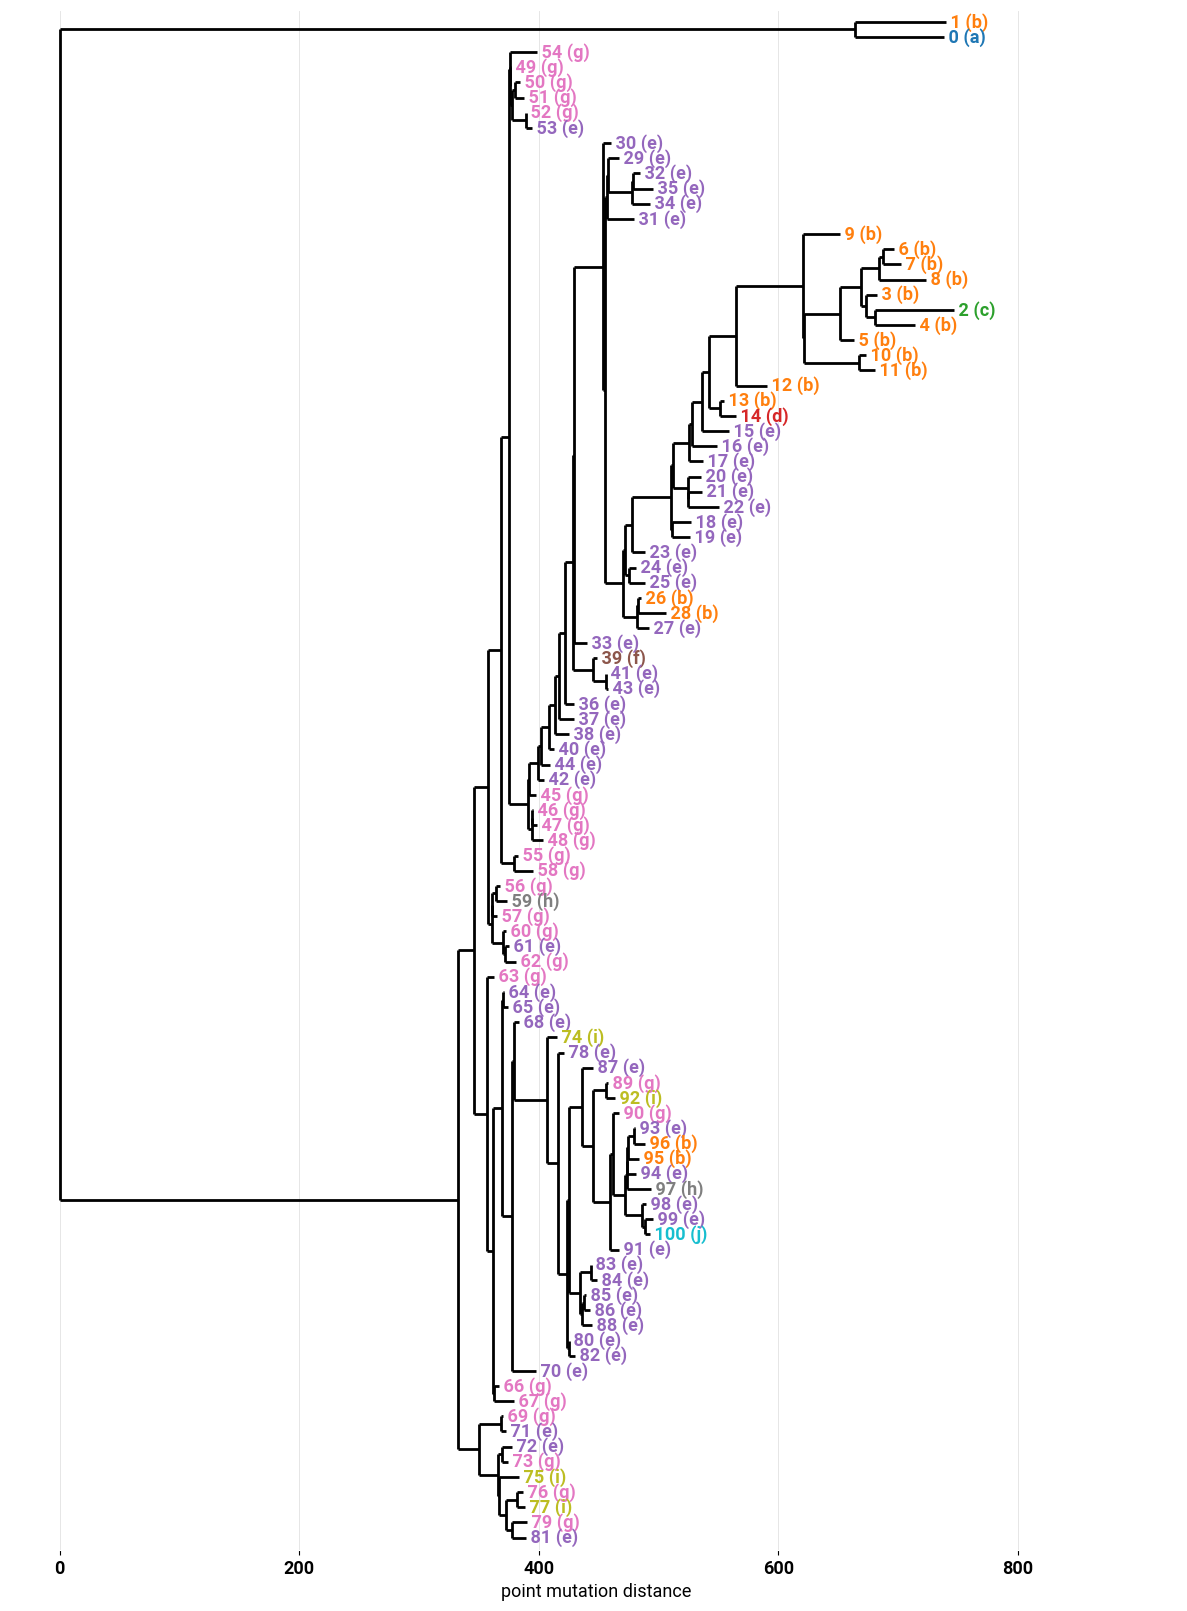

teeplots/parsimony_tree/viz=draw+ext=.pdf
teeplots/parsimony_tree/viz=draw+ext=.png


<Figure size 1500x2000 with 0 Axes>

In [17]:
def name_function(node):
    try:
        return str(int(node.name)) + " (" + morphs[int(node.name)] + ")" if 'Inner' not in str(node) else None
    except TypeError:
        return ""
    
def set_color(x):
    if x:
        return mpl_colors.to_hex('C' + str(ord(x[-2]) - ord('a')))
    
tp.tee(
    Phylo.draw,
    pars_tree,
    label_func=name_function,
    branch_labels=None,
    label_colors=set_color,
    xlabel=["point mutation distance"],
    ylabel=[""],
    yticks={"ticks": [0]},
    grid={"visible": True, "which": "both", "axis": "x", "color": "gainsboro", "linewidth": "0.5"},
    teeplot_subdir="parsimony_tree"
)

In [18]:
sorted_pars_tree = deepcopy(pars_tree)
sorted_pars_tree = MyTree(sorted_pars_tree.clade)
sorted_pars_tree.sort_tree(reverse=True)

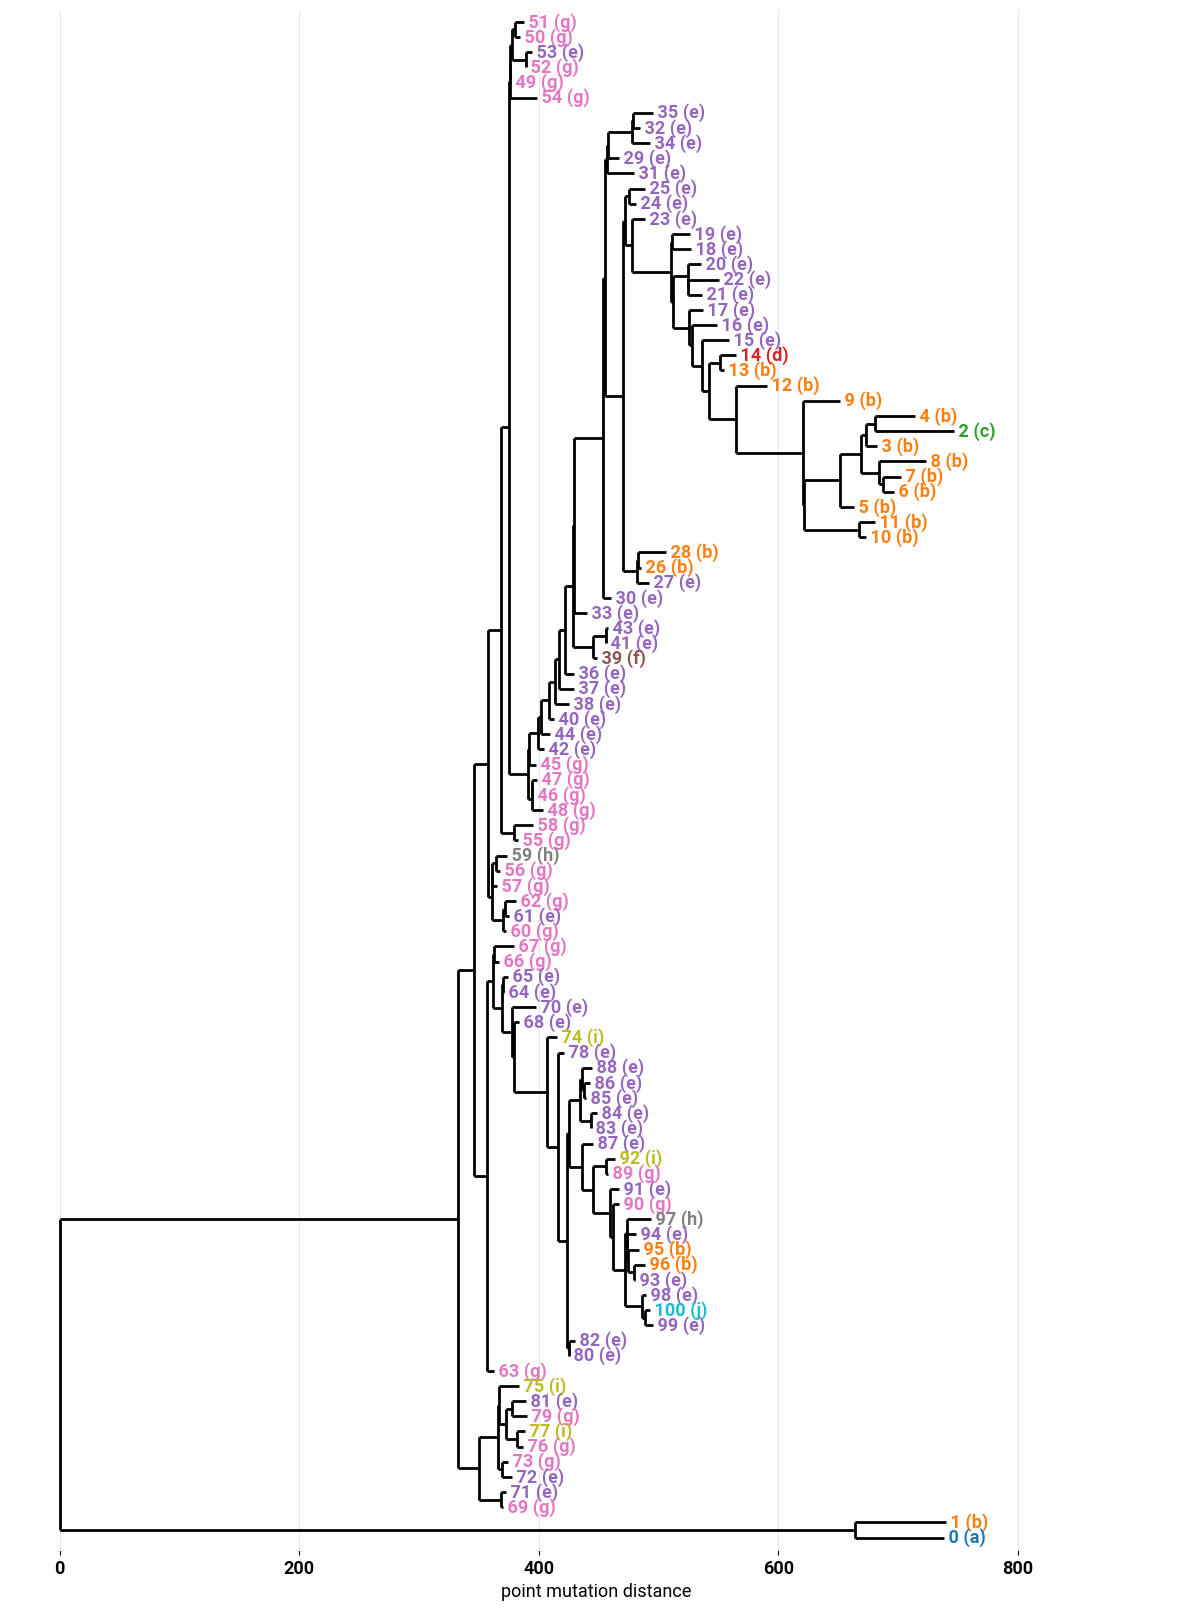

teeplots/parsimony_tree/viz=draw+ext=.pdf
teeplots/parsimony_tree/viz=draw+ext=.png


<Figure size 1500x2000 with 0 Axes>

In [19]:
tp.tee(
    Phylo.draw,
    sorted_pars_tree,
    label_func=name_function,
    branch_labels=None,
    label_colors=set_color,
    xlabel=["point mutation distance"],
    ylabel=[""],
    yticks={"ticks": [0]},
    grid={"visible": True, "which": "both", "axis": "x", "color": "gainsboro", "linewidth": "0.5"},
    teeplot_subdir="parsimony_tree"
)

In [20]:
rerooted_pars_tree = deepcopy(sorted_pars_tree)
rerooted_pars_tree.root_with_outgroup({"name": "0000000002"})
rerooted_pars_tree.sort_tree(reverse=True)

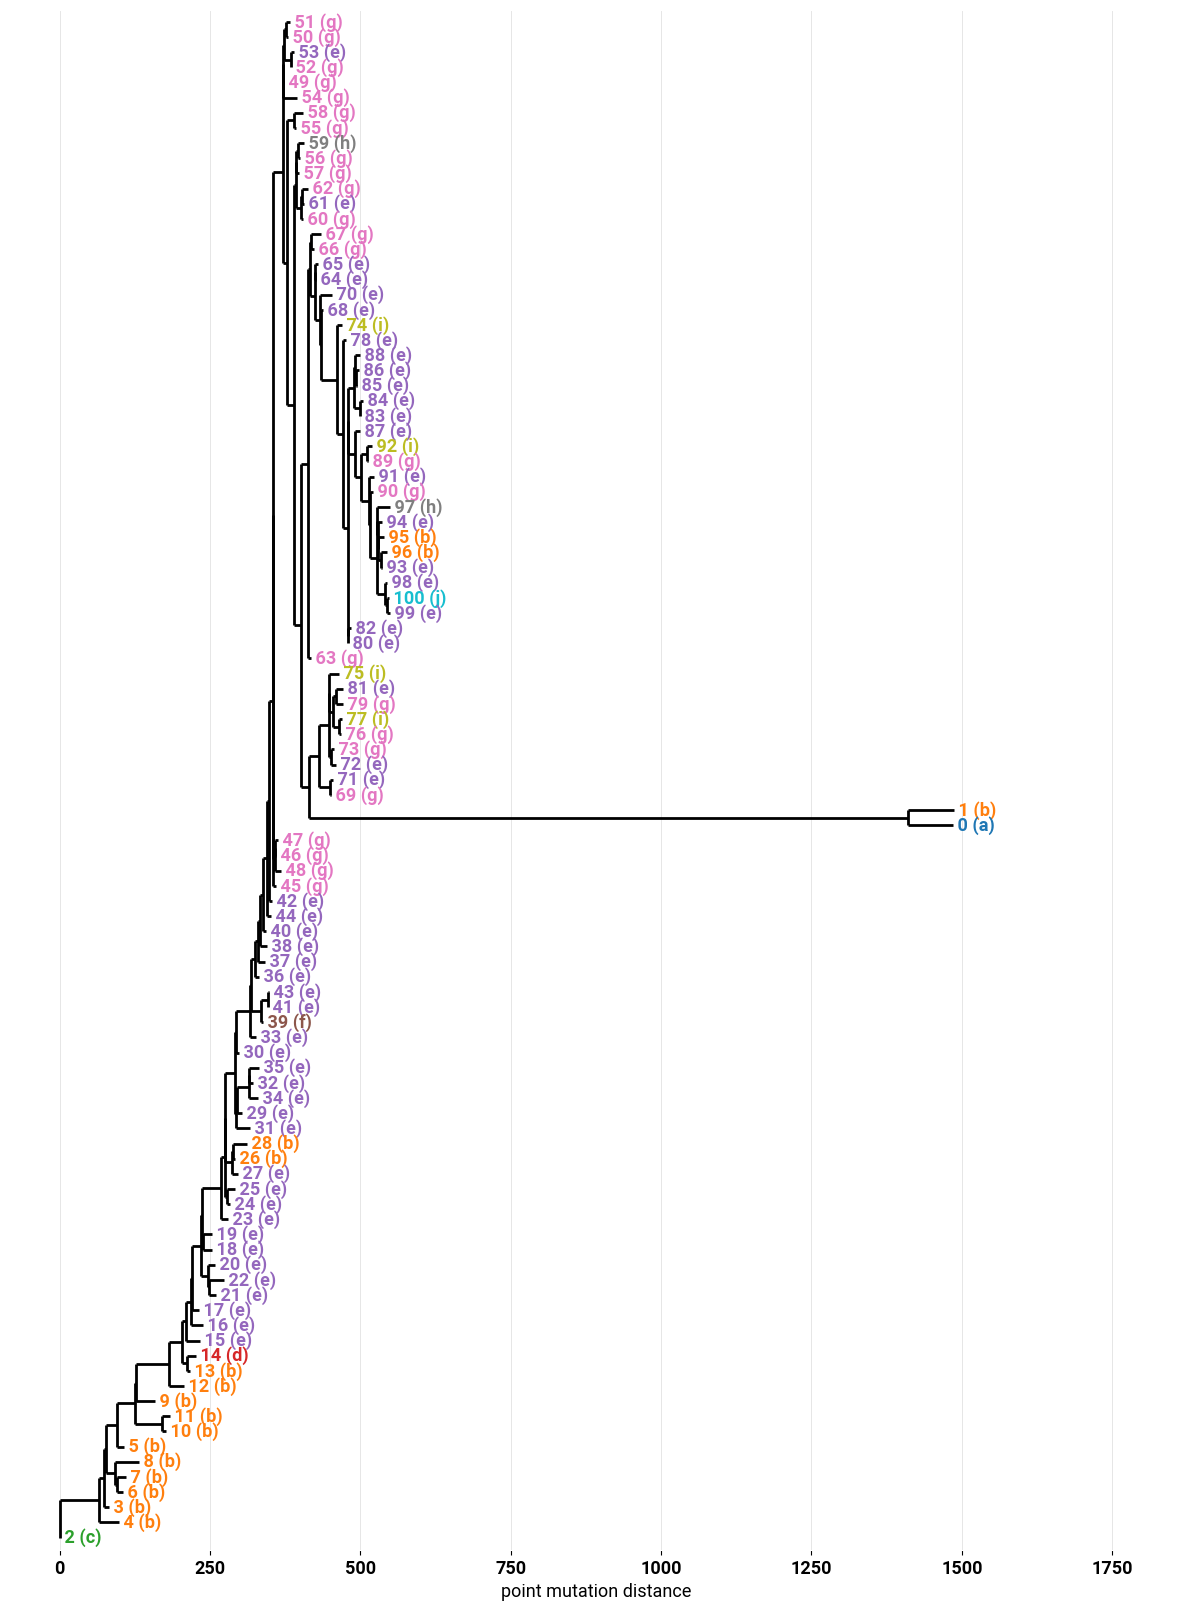

teeplots/parsimony_tree/viz=draw+ext=.pdf
teeplots/parsimony_tree/viz=draw+ext=.png


<Figure size 1500x2000 with 0 Axes>

In [21]:
tp.tee(
    Phylo.draw,
    rerooted_pars_tree,
    label_func=name_function,
    branch_labels=None,
    label_colors=set_color,
    xlabel=["point mutation distance"],
    ylabel=[""],
    yticks={"ticks": [0]},
    grid={"visible": True, "which": "both", "axis": "x", "color": "gainsboro", "linewidth": "0.5"},
    teeplot_subdir="parsimony_tree"
)

In [22]:
# store parsimony trees
Phylo.write(pars_tree, "data/parsimony_tree.xml", "phyloxml")
Phylo.write(sorted_pars_tree, "data/sorted_parsimony_tree.xml", "phyloxml")
Phylo.write(rerooted_pars_tree, "data/rerooted_pars_tree.xml", "phyloxml")

1